# Training with all representations

In [1]:
!python -m pip list

Package                Version  
---------------------- ---------
absl-py                0.12.0   
anyio                  2.2.0    
argon2-cffi            20.1.0   
astunparse             1.6.3    
async-generator        1.10     
attrs                  20.3.0   
Babel                  2.9.0    
backcall               0.2.0    
bleach                 3.3.0    
cachetools             4.2.1    
certifi                2020.12.5
cffi                   1.14.5   
chardet                4.0.0    
cycler                 0.10.0   
dask                   2021.3.0 
decorator              4.4.2    
defusedxml             0.7.1    
entrypoints            0.3      
flatbuffers            1.12     
gast                   0.3.3    
google-auth            1.27.1   
google-auth-oauthlib   0.4.3    
google-pasta           0.2.0    
grpcio                 1.32.0   
h5py                   2.10.0   
idna                   2.10     
ipykernel              5.5.0    
ipython                7.21.0   
ipython-ge

In [2]:
!nvidia-smi

Wed Mar 24 20:52:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070    On   | 00000000:01:00.0 Off |                  N/A |
| 26%   58C    P0    39W / 151W |     72MiB /  8118MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random
import tqdm
import seaborn as sn
import numpy as np
import time

from collections import defaultdict

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tqdm.contrib.concurrent import process_map, thread_map

from utils import yaml_load, yaml_write, get_section

%matplotlib inline

# General functions

Here we are going to define some general functions, for different purposes, used along the whole notebook.

In [4]:
def create_model(n_nodes, n_features, n_classes, learning_rate):
    N = n_nodes
    F = n_features
    
    # Model definition
    conv   = GraphConv(45,activation='relu',use_bias=False)
    mincut = MinCutPool(N // 2)
    conv2  = GraphConv(55,activation='relu',use_bias=False)
    pool   = GlobalAttnSumPool()

    # First Graph Layers
    X1_in = Input(shape=(N, F))
    A1_in = Input((N, N))
    gc2_1 = conv([X1_in, A1_in])
    gc2_1, A1 = mincut([gc2_1,A1_in])
    gc2_1 = conv2([gc2_1, A1])
    pool_1 =  pool(gc2_1)
    d1 = Dense(200,activation='relu')(pool_1)

    # Second Graph Layers
    X2_in = Input(shape=(N, F))
    A2_in = Input((N, N))
    gc2_2 = conv([X2_in, A2_in]) # Notice that both graphs shares layers (shared weights)
    gc2_2, A2 = mincut([gc2_2,A2_in])
    gc2_2 = conv2([gc2_2, A2])
    pool_2 = pool(gc2_2)
    d2 = Dense(200,activation='relu')(pool_2)

    # Dense final layers
    merged = Concatenate()([d1, d2])

    merged1 = Dense(800,activation='relu')(merged)
    merged2 = Dense(32,activation='relu')(merged1)

    classe = Dense(n_classes, name="class",activation="softmax")(merged2)
    speedup = Dense(1, name="speddup")(merged2)

    # Build model
    model = Model(inputs=[X1_in, A1_in,X2_in, A2_in], outputs=[classe,speedup])
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mse'], loss_weights=[1, 0.00005], weighted_metrics=['acc'])
    return model

In [5]:
# Load and prepare inputs, in the .npz file, to train by the model
def get_inputs(input_data_file: str, test_size: float) -> tuple:
    """Load and prepare samples to be used by the model. Also, splits the samples in train and test sets. 
    
    Parameters:
        input_data_file (str): Numpy file containing the graphs, features and speedups from all samples
        test_size (float): Number of samples to used as test
        
    Returns:
        A tuple with 6 elements (in order), being:
        * The graphs used to train
        * The graphs used to test
        * The graph features used to train
        * The graph features used to test
        * The speedup used to train
        * The speedup used to test
    """
    # Read all data
    with np.load(input_data_file, allow_pickle=True) as all_data:
        graphs = all_data['graphs']        # Graphs matrices
        features = all_data['features']    # Features matrices
        speedups = all_data['speedups']    # Speedup matrices (targets)

    print(f'Data loaded from {input_data_file}')
    
    # Generate classed based on speedup [0-4]
    y_c = np.zeros(shape=(speedups.shape[0],5))

    for i in range(0, speedups.shape[0]):
        if speedups[i] < 0.45:
            y_c[i,0]=1
        elif (speedups[i] <= 0.80 and speedups[i] >= 0.45):
            y_c[i,1]=1
        elif (speedups[i] <= 1.33 and speedups[i] > 0.80):
            y_c[i,2]=1
        elif speedups[i] > 1.33:
            y_c[i,3]= 1
        y_c[i,4] =speedups[i]
    speedups = y_c

    print(f"""Speedup classes generated from data. Number of elements 
        Class A: {int(sum(speedups[:,0]))},
        Class B: {int(sum(speedups[:,1]))},
        Class C: {int(sum(speedups[:,2]))},
        Class D: {int(sum(speedups[:,3]))},
    """)
    
    # Remove 0 columns in nodes features
    #idx = np.argwhere(np.all(X[..., :] == 0, axis=(0,1,2)))
    #X = np.delete(X, idx, axis=3)

    print(f"""Datas:
        Graphs shape:   {graphs.shape}
        Features shape: {features.shape}
        Speedups shape: {speedups.shape} 
    """)

    # Preprocess all graphs with Spektral package
    graphs[:,0,:,:] = GraphConv.preprocess(graphs[:,0,:,:]).astype('f4')
    graphs[:,1,:,:] = GraphConv.preprocess(graphs[:,1,:,:]).astype('f4')
    print("Graphs preprocessed!")
    
    # Split train and test sets
    graphs_train, graphs_test, features_train, features_test, speedups_train, speedups_test = train_test_split(graphs, features, speedups, shuffle=True, test_size=test_size)
    print("Dataset splitted!")
    
    return graphs_train, graphs_test, features_train, features_test, speedups_train, speedups_test

In [6]:
# Function used to store information about training
def dump_info(data_dir: str, filename: str, values: dict):
    """Create directories and store informations about training
    
    Parameters:
        data_dir (str): Directory to store information about training (model, weights, results, etc.)
        filename (str): Name of the file to save information about
        values (dict): Dictionary with information
    
    Returns:
        None
    """
    # Create the directories to store information about training
    os.makedirs(data_dir, exist_ok=True)
    output_file = os.path.join(data_dir, filename)
    yaml_write(output_file, values)    
    print(f'Information saved to {output_file}')

In [7]:
# Save model topology and weights
def save_model(data_dir: str, model: Model):
    """Save model topology and weights to files (model.yaml and weights.h5, respectively) in data_dir
    
    Parameters:
        data_dir (str): Directory to store model topology and weights
        model: Model to save
    
    Returns:
        None
    """
    # Saving model and weights
    output_model_file = os.path.join(data_dir, 'model.yaml')
    yaml_write(output_model_file, model.to_yaml())
    print(f'Model saved to {output_model_file}')

    output_weights_file = os.path.join(data_dir, 'weights.h5')
    model.save_weights(output_weights_file)
    print(f"Weights saved to file {output_weights_file}")

# Training with CFG graphs

## Shape 150x150

Information saved to ./model_data/GNN_cfg_150x150_1616629924.5479534/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cfgs_20000samples_150x150.npz
Speedup classes generated from data. Number of elements 
        Class A: 5000,
        Class B: 5000,
        Class C: 5000,
        Class D: 5000,
    
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 67)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 1

841

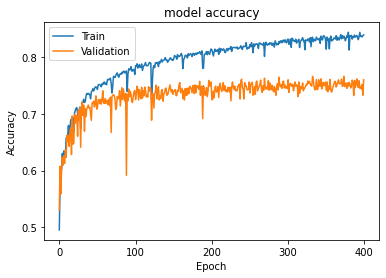

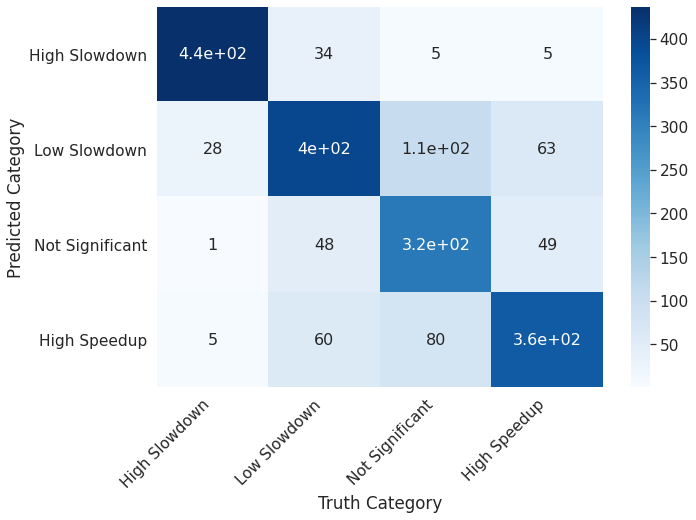

In [8]:
# Configuration information about training
config = {
    'input_data': './data/cfgs_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cfg',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

## Shape 300x300

Information saved to ./model_data/GNN_cfg_300x300_1616632071.1668575/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cfgs_20000samples_300x300.npz
Speedup classes generated from data. Number of elements 
        Class A: 5000,
        Class B: 5000,
        Class C: 5000,
        Class D: 5000,
    
Datas:
        Graphs shape:   (20000, 2, 300, 300)
        Features shape: (20000, 2, 300, 67)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 67)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300,

19212

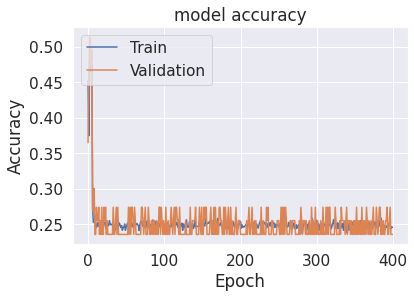

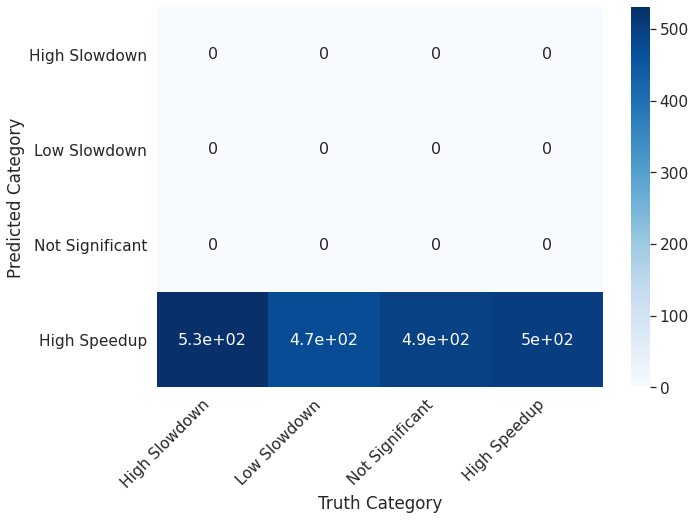

In [9]:
# Configuration information about training
config = {
    'input_data': './data/cfgs_20000samples_300x300.npz',   # Name of the file with samples
    'data_dir_tag': 'cfg',    # Tag for directory name
    'n_nodes': 300,       # Number of nodes in graphs
    'n_features': 67,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

---

# Training with CDFG

## Training with control, data and call edges. Shape 150x150

Information saved to ./model_data/GNN_cdfg-control-data-call_150x150_1616636783.814992/info.yaml
Loading inputs and split into train and test sets
Data loaded from ./data/cdfgs_control-data-call_20000samples_150x150.npz
Speedup classes generated from data. Number of elements 
        Class A: 5000,
        Class B: 5000,
        Class C: 5000,
        Class D: 5000,
    
Datas:
        Graphs shape:   (20000, 2, 150, 150)
        Features shape: (20000, 2, 150, 200)
        Speedups shape: (20000, 5) 
    
Graphs preprocessed!
Dataset splitted!
Inputs loaded!
Model created!
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 200)]   0                                            
__________________________________________________________________________________________________
input_

19803

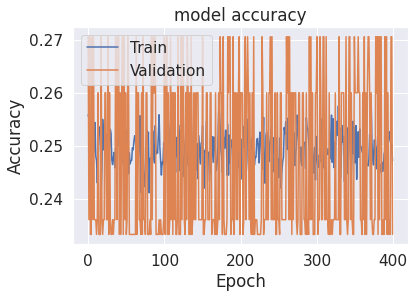

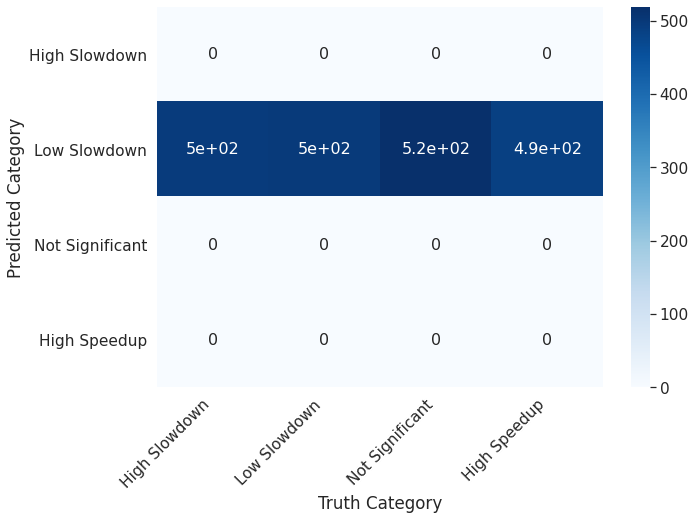

In [12]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-data-call_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-data-call',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

## Training with control and data edges only. Shape 150x150

In [13]:
# Configuration information about training
config = {
    'input_data': './data/cdfgs_control-data_20000samples_150x150.npz',   # Name of the file with samples
    'data_dir_tag': 'cdfg-control-data',    # Tag for directory name
    'n_nodes': 150,       # Number of nodes in graphs
    'n_features': 200,     # Original feature dimensionality
    'n_classes': 4,       # Number of output classes
    'epochs': 400,        # Number of training epochs
    'batch_size': 16,     # Number of samples per batch
    'learning_rate': 1e-2,# Training learning rate
    'test_size': 0.10,    # Percentage of samples to be used in test set (in relation to total number of samples)
    'validation_size': 0.10,    # Percentage of samples to be used in validation set (in relation to number of training samples)
    'samples': 20000,     # Number of samples in dataset (OPTIONAL)
}

# Create directory and write configuration information
data_dir = f"./model_data/GNN_{config['data_dir_tag']}_{config['n_nodes']}x{config['n_nodes']}_{time.time()}"
dump_info(data_dir, 'info.yaml', config)

print('Loading inputs and split into train and test sets')
# Load inputs and create train and and test sets
graphs_train, graphs_test, features_train, features_test, y_train, y_test = get_inputs(config['input_data'], test_size=config['test_size'])
print("Inputs loaded!")

# Create GNN model
model = create_model(config['n_nodes'], config['n_features'], config['n_classes'], config['learning_rate'])
print('Model created!')
model.summary()

# -----------------------------------------------
# ----------------- Train model -----------------
# -----------------------------------------------
print('Start training')
start_time = time.time()
history = model.fit([features_train[:,0,:,:], graphs_train[:,0,:,:], features_train[:,1,:,:], graphs_train[:,1,:,:]], [y_train[:,0:4], y_train[:,4]],
          batch_size=config['batch_size'], validation_split=config['validation_size'], epochs=config['epochs'], verbose=1)
end_time = time.time()
print(f'Training took {end_time-start_time} seconds..')

# Dump training information to files
dump_info(data_dir, 'training_history.yaml', history.history)
dump_info(data_dir, 'training_time.yaml', {'time': end_time-start_time})
# Save model and weights to files
save_model(data_dir, model)

# Plot accuracy per epoch in train and validation sets
plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
figure_file = os.path.join(data_dir, "model_accuracy.pdf")
plt.savefig(figure_file)
print(f"Accuracy per epoch figure saved to {figure_file}")


# --------------------------------------------------
# ----------------- Evaluate model -----------------
# --------------------------------------------------
print('Evaluating model.')
eval_results = model.evaluate([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]], [y_test[:,0:4],y_test[:,4]],
                              batch_size=config['batch_size'])
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

# Dump evaluation information to files
dump_info(data_dir, 'evaluation.yaml', {'test_loss': eval_results[0], 'test_accuracy': eval_results[1]})

# Printing confusion matrix
print("Confusion matrix:")
pred_vals = model.predict([features_test[:,0,:,:], graphs_test[:,0,:,:], features_test[:,1,:,:], graphs_test[:,1,:,:]])
pred_vals = np.argmax(pred_vals[0], axis=-1)
test_vals = np.argmax(y_test[:,0:4], axis=-1)
cm=confusion_matrix(pred_vals,test_vals)
print(cm)

# Plot confusion matrix
labels = ['High Slowdown', 'Low Slowdown', 'Not Significant', 'High Speedup']
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
ax = sn.heatmap(cm, cmap="Blues", annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('Truth Category')
ax.set_ylabel('Predicted Category')

# Save confusion matrix
figure_file = os.path.join(data_dir, "confusion_matrix.pdf")
plt.savefig(figure_file)
print(f"Confusion matrix figure saved to {figure_file}")

# Cleanup
gc.collect()

Information saved to ./model_data/GNN_cdfg-control-data_150x150_1616639189.1082768/info.yaml
Loading inputs and split into train and test sets


FileNotFoundError: [Errno 2] No such file or directory: './data/cdfgs_control-data_20000samples_150x150.npz'